In [1]:
import numpy as np
import emcee
import celerite
import matplotlib.pyplot as plt

from celerite import terms
from scipy.optimize import minimize

In [3]:
def DRW_process(t,tau,SF,m):  
    r=np.diff(t)/tau
    ls=[np.random.normal(m,SF/1.414,1)[0]]
    for i in range(len(t)-1):
        if r[i]<0:raise TimeSerieError('时间序列未排序')
        stdev=(1-np.exp(-2*r[i]))**0.5*SF/1.414
        loc=ls[i]*np.exp(-r[i])+m*(1-np.exp(-r[i]))
        ls.append(np.random.normal(loc,stdev,1)[0])
    return np.array(ls)

def log_like(params,y,gp,method):
    gp.set_parameter_vector(params)
    if method=='MAP':
        return -gp.log_likelihood(y)+0.5*params[0]-params[1]*0.5
    else: return -gp.log_likelihood(y)

def log_probability(params,y,gp):
        gp.set_parameter_vector(params)
        lp=gp.log_prior()
        log_a=gp.get_parameter_dict().get('kernel:log_a')
        log_c=gp.get_parameter_dict().get('kernel:log_c')
        if not np.isfinite(lp):
            return -np.inf
        return gp.log_likelihood(y)+lp-0.5*log_a+log_c*0.5


def DRW_fit(t,s,err,method='MAX',tl=[1,5000],sl=[0.02,0.7]):
    # Set up the GP model
    bounds=dict(log_a=(2*np.log(sl[0]),2*np.log(sl[1])),
                log_c=(-np.log(tl[1]),-np.log(tl[0])))
    kernel=terms.RealTerm(log_a=np.log(0.1414),log_c=-np.log(400),bounds=bounds)
    gp=celerite.GP(kernel,mean=np.mean(s),fit_mean=True)
    gp.compute(t,err)
    # Fit for the maximum likelihood parameters
    initial_params = gp.get_parameter_vector()
    soln=minimize(log_like, initial_params,method="L-BFGS-B",args=(s,gp,method))
    
    gp.set_parameter_vector(soln.x)
    rt=np.exp(-gp.get_parameter_dict().get('kernel:log_c'))#MLE or MAP
    rs=np.exp(gp.get_parameter_dict().get('kernel:log_a')/2)
    if method=='MLE' or method=='MAP':
        return np.array([rt,rs])   
    #MCMC
    initial=np.array(soln.x)
    ndim, nwalkers=len(initial),16
    sampler=emcee.EnsembleSampler(nwalkers,ndim,log_probability,args=(s,gp))
    #Running burn-in
    p0=initial+1e-4*np.random.randn(nwalkers,ndim)
    p0,lp,_=sampler.run_mcmc(p0,125)    
    #Running production
    sampler.reset()
    sampler.run_mcmc(p0,500)
    #Markov chains
    t_chain=np.exp(np.sort(-sampler.flatchain[:,1]))
    s_chain=np.exp(np.sort(sampler.flatchain[:,0]/2))
    return t_chain

def MLE_chain(t,s,err,tl=[1,5000],sl=[0.02,0.7]):
    def log_like2(params,y,gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)
    
    def log_prob(params,y,gp):
        gp.set_parameter_vector(params)
        lp = gp.log_prior()
        if not np.isfinite(lp):
            return -np.inf
        return gp.log_likelihood(y) + lp
        
    # Set up the GP model
    bounds=dict(log_a=(2*np.log(sl[0]),2*np.log(sl[1])),
                log_c=(-np.log(tl[1]),-np.log(tl[0])))
    kernel=terms.RealTerm(log_a=np.log(0.1414),log_c=-np.log(400),bounds=bounds)
    gp=celerite.GP(kernel,mean=np.mean(s),fit_mean=True)
    gp.compute(t,err)
    # Fit for the maximum likelihood parameters
    initial_params = gp.get_parameter_vector()
    soln=minimize(log_like2, initial_params,method="L-BFGS-B",args=(s,gp))
    
    gp.set_parameter_vector(soln.x)
    rt=np.exp(-gp.get_parameter_dict().get('kernel:log_c'))
    rs=np.exp(gp.get_parameter_dict().get('kernel:log_a')/2)
    #MCMC
    initial=np.array(soln.x)
    ndim, nwalkers=len(initial),32
    sampler=emcee.EnsembleSampler(nwalkers,ndim,log_prob,args=(s,gp))
    #Running burn-in
    p0=initial+1e-4*np.random.randn(nwalkers,ndim)
    p0,lp,_=sampler.run_mcmc(p0,500)    
    #Running production
    sampler.reset()
    sampler.run_mcmc(p0,2000)
    #Markov chains
    t_chain=np.exp(np.sort(-sampler.flatchain[:,1]))
    s_chain=np.exp(np.sort(sampler.flatchain[:,0]/2))
    return t_chain

In [103]:
t=np.sort(np.random.randint(0,2922,60)+np.random.uniform(-0.13,0.13,60))
y=DRW_process(t,292,0.2,18)
ls_sdss=[]
lsigma=[]
for i in range(60):
    #s=np.sqrt(0.004**2+np.exp(1.63*(y[i]-22.55)))
    s=np.sqrt(0.013**2+np.exp(2*(y[i]-23.36)))
    lsigma.append(s)
    ls_sdss.append(np.random.normal(y[i],s,1)[0])
s_sdss=np.array(ls_sdss)
sigma=np.array(lsigma)

In [105]:
c1="#009ad6" #PE
c2='#f15a22' #MLE
c3='#7fb80e' #PM
c4='#aa2116' #MAP

MAP=DRW_fit(t,s_sdss,sigma,method='MAP')[0]
MLE=DRW_fit(t,s_sdss,sigma,method='MLE')[0]
chain=DRW_fit(t,s_sdss,sigma)
mle_chain=MLE_chain(t,s_sdss,sigma)
print('MLE=',MLE,'MAP=',MAP)
print('PM=',np.median(chain),'PE=',np.mean(chain))

MLE= 222.8726361356863 MAP= 191.971791824751
PM= 280.3853930211427 PE= 419.6035967421757


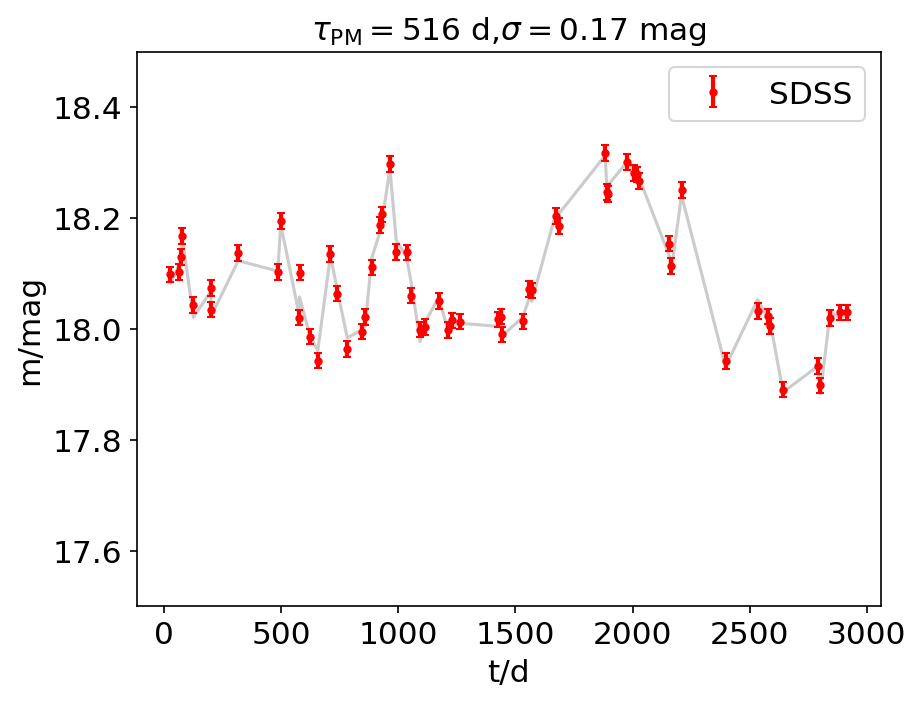

0.10668258600064605


In [42]:
plt.figure(dpi=150)
plt.plot(t,y,'0.8')
plt.errorbar(t,s_sdss,yerr=sigma,fmt='.',ecolor='r',color='r',elinewidth=2,capsize=2,label='SDSS')
plt.title(r'$\tau_{\rm PM}=516$ d,$\sigma=0.17$ mag',fontsize=15)
plt.xlabel('t/d',fontsize=15)
plt.ylabel('m/mag',fontsize=15)
plt.ylim(17.5,18.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15) 
plt.legend(fontsize=15)
plt.show()
print(np.sqrt(np.var(s_sdss)*len(s_sdss)/(len(s_sdss)-1)-np.mean(np.power(sigma,2))))

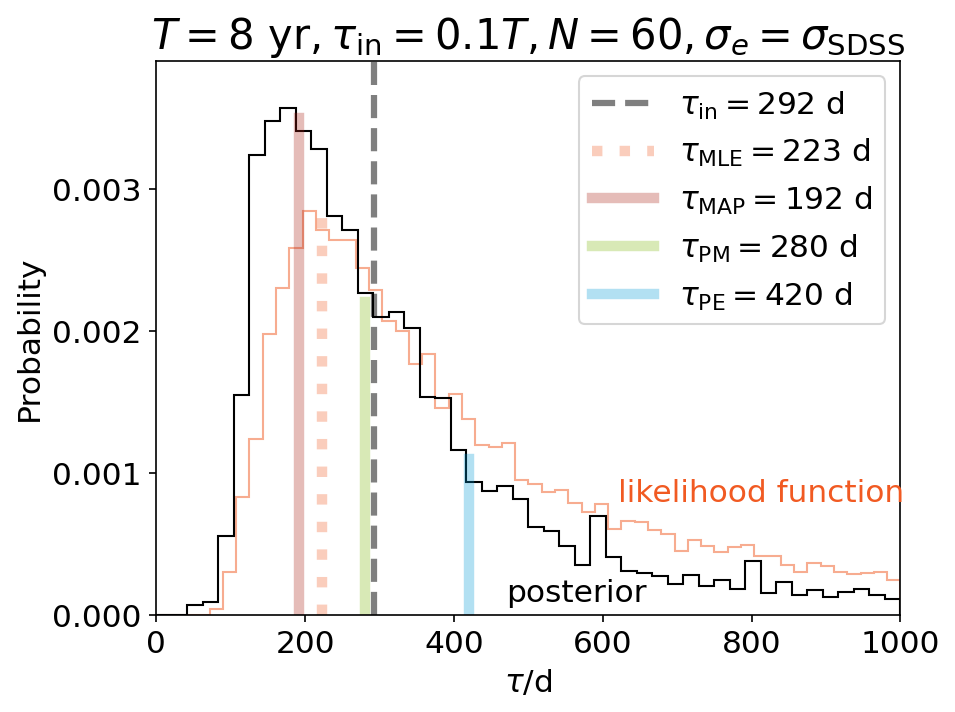

In [112]:
plt.figure(dpi=150)
plt.hist(mle_chain,bins=56,range=(0,1000),density=True,color=c2,histtype='step',alpha=0.5)
plt.hist(chain,bins=48,range=(0,1000),density=True,color='k',histtype='step')
plt.plot(np.full(10,292),np.linspace(0,0.0046,10),'--',lw=3,color='k',alpha=0.5,label=r'$\tau_{\rm in}=292$ d')

plt.plot(np.full(10,MLE),np.linspace(0,0.0028,10),':',lw=5,color=c2,alpha=0.3,label=r'$\tau_{\rm MLE}=223$ d')
plt.plot(np.full(10,MAP),np.linspace(0,0.0035,10),lw=5,color=c4,alpha=0.3,label=r'$\tau_{\rm MAP}=192$ d')
plt.plot(np.full(10,np.median(chain)),np.linspace(0,0.0022,10),lw=5,color=c3,alpha=0.3,
         label=r'$\tau_{\rm PM}=280$ d')
plt.plot(np.full(10,np.mean(chain)),np.linspace(0,0.0011,10),lw=5,color=c1,alpha=0.3,
        label=r'$\tau_{\rm PE}=420$ d')

plt.text(470,0.0001,r'posterior',fontsize=15)
text=plt.text(620,0.0008,r'likelihood function',fontsize=15)
text.set_color(c2)

plt.title(r'$T=8\ {\rm yr},\tau_{\rm in}=0.1T,N=60,\sigma_e=\sigma_{\rm SDSS}$',fontsize=20)
plt.xlabel(r'$\tau$/d',fontsize=15)
plt.ylabel('Probability',fontsize=15)
plt.legend(fontsize=15)
plt.xlim(0,1000)
plt.ylim(0,0.0039)
plt.xticks(fontsize=15)
plt.yticks([0,0.001,0.002,0.003],fontsize=15)
plt.show()

In [2]:
x=np.loadtxt('posterior_pm.txt')[:,0]
print(np.mean(x),np.median(x))

285.7122288294948 249.00852118027666


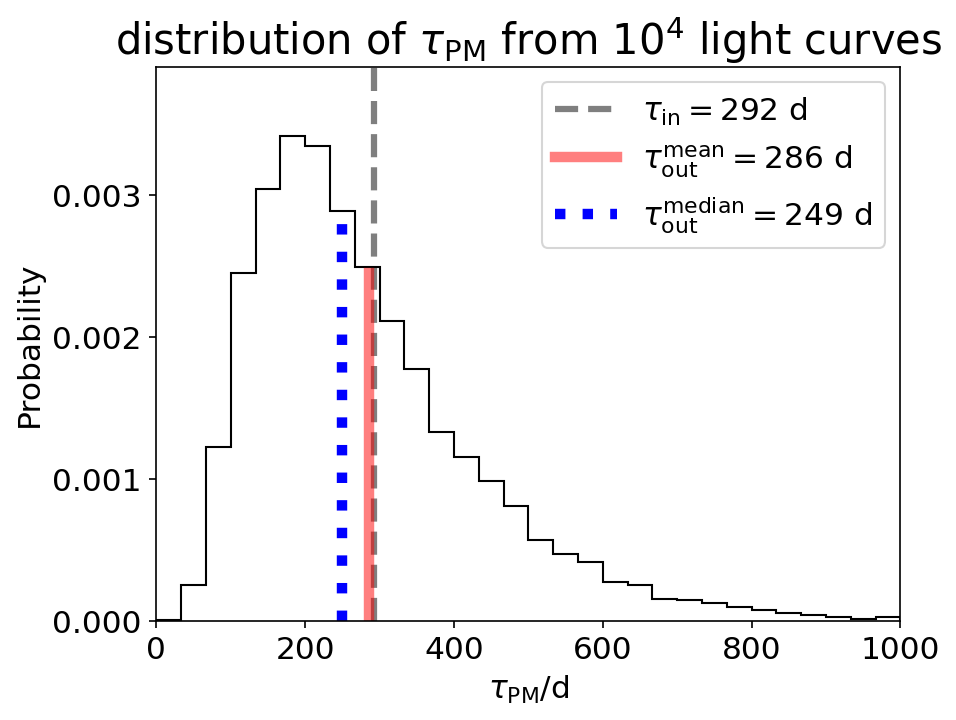

In [3]:
plt.figure(dpi=150)
plt.hist(x,bins=30,range=(0,1000),histtype='step',density=True,color='k')
plt.plot(np.full(10,292),np.linspace(0,0.0039,10),'--',lw=3,color='k',alpha=0.5,label=r'$\tau_{\rm in}=292$ d')

plt.plot(np.full(10,286),np.linspace(0,0.00245,10),lw=5,color='r',alpha=0.5,
         label=r'$\tau_{\rm out}^{\rm mean}=286$ d')
plt.plot(np.full(10,249),np.linspace(0,0.0029,10),':',lw=5,color='b',label=r'$\tau_{\rm out}^{\rm median}=249$ d')

plt.title(r'distribution of $\tau_{\rm PM}$ from $10^4$ light curves',fontsize=20)
plt.xlabel(r'$\tau_{\rm PM}$/d',fontsize=15)
plt.ylabel('Probability',fontsize=15)
plt.legend(fontsize=15)
plt.xlim(0,1000)
plt.ylim(0,0.0039)
plt.xticks(fontsize=15)
plt.yticks([0,0.001,0.002,0.003],fontsize=15)
plt.show()